In [2]:
import numpy as np
import pandas as pd

#====== Eingabe ============
pop = 100_000  # Normierung
n = 200_000    # Anzahl der MC-Simulationen

attack_rates = [0.15, 0.30, 0.50]
rate = 0.30
spalte= "consult_total"

tri = dict(
    consult_frac=(0.30, 0.50, 0.70),
    hosp_per_consult=(0.014, 0.027, 0.040),
    death_per_consult=(0.004, 0.007, 0.010),
)

rng = np.random.default_rng(42)

#==============================
records = []

for ar in attack_rates:
    cf = rng.triangular(*tri["consult_frac"], size=n)
    hp = rng.triangular(*tri["hosp_per_consult"], size=n)
    dp = rng.triangular(*tri["death_per_consult"], size=n)

    ill = pop * ar
    consult = ill * cf
    hosp = consult * hp
    deaths = consult * dp

    df_ar = pd.DataFrame({
        "attack_rate": ar,
        "ill_total": ill,
        "consult_total": consult,
        "hosp_total": hosp,
        "deaths_total": deaths,
    })

    records.append(df_ar)

# DAS ist das gesuchte Objekt
sim = pd.concat(records, ignore_index=True)


df = sim[sim["attack_rate"] == rate]
H = df[spalte].to_numpy()

def triangular_weights(W: int, peak_frac: float = 0.4):
    x = np.arange(W)
    peak = peak_frac * (W - 1)
    w = 1 - np.abs(x - peak) / max(peak, W - 1 - peak)
    w = np.clip(w, 0, None)
    return w / w.sum()


weeks = [2, 4, 6, 8, 10, 12]
peak_frac = 0.4

peaks = {}

for W in weeks:
    w = triangular_weights(W, peak_frac=peak_frac)
    print(w)
    factor = w.max()
    peaks[W] = factor * H


[1. 0.]
[0.1875 0.5    0.3125 0.    ]
[0.11111111 0.22222222 0.33333333 0.22222222 0.11111111 0.        ]
[0.08139535 0.13953488 0.19767442 0.23255814 0.1744186  0.11627907
 0.05813953 0.        ]
[0.06382979 0.09929078 0.13475177 0.17021277 0.17730496 0.14184397
 0.10638298 0.07092199 0.03546099 0.        ]
[0.05238095 0.07619048 0.1        0.12380952 0.14761905 0.14285714
 0.11904762 0.0952381  0.07142857 0.04761905 0.02380952 0.        ]


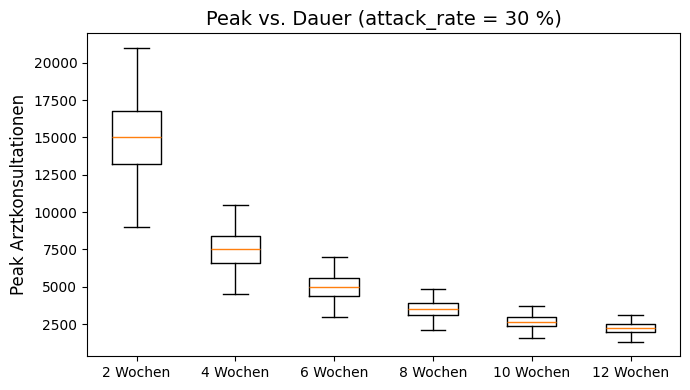

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))

ax.boxplot(
    [peaks[W] for W in weeks],
    tick_labels=[f"{W} Wochen" for W in weeks],
    showfliers=False,
)
rate1=int(rate*100)
ax.set_ylabel("Peak Arztkonsultationen",fontsize=12)
ax.set_title(f"Peak vs. Dauer (attack_rate = {rate1} %)",fontsize=14)

plt.tight_layout()
plt.savefig("outputs/figures/Peak/Peak_Arztkonsultationen_vs_Dauer_attack_30.pdf")
plt.show()
